In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import itertools
import spacy
import os
import math
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from collections import defaultdict
import numpy as np

In [2]:
# Set the path to your folder containing CSV files
folder_path = 'data12B_Total'

csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

all_dataframes = []
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    all_dataframes.append(df)

# Concatenate into one DataFrame
df_all = pd.concat(all_dataframes, ignore_index=True)

df_all

,Technique,Topic,Target Level,Output Length,Model,Prompt,Rewrite Prompt,Text,Flesch-Kincaid,Flesch Ease,ARI,SMOG,Gunning Fog,Coleman-Liau,Spache,Linsear Write
0,Two-Step,human aging,High School,200,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,Rewrite the following text to match the readab...,13.9,27.62,15.5,15.2,15.85,15.9,6.9,12.0
1,Two-Step,human aging,High School,200,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,Rewrite the following text to match the readab...,13.6,28.54,15.8,14.9,15.91,16.53,6.89,12.166667
2,Two-Step,human aging,High School,200,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,Rewrite the following text to match the readab...,14.5,26.1,16.2,15.2,16.35,15.95,6.89,11.833333
3,Two-Step,human aging,High School,200,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,Rewrite the following text to match the readab...,11.9,43.73,13.7,13.8,14.44,13.29,6.4,11.333333
4,Two-Step,human aging,High School,200,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,Rewrite the following text to match the readab...,14.8,25.39,16.7,15.6,16.42,16.24,6.81,12.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16022,Two-Step,human aging,Advanced College,100,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,Rewrite the following text to match the readab...,14.8,19.87,16.8,15.0,16.52,17.57,7.32,12.5
16023,Two-Step,human aging,Advanced College,100,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,Rewrite the following text to match the readab...,14.5,26.1,18.2,15.7,17.37,18.33,7.4,12.833333
16024,Two-Step,human aging,Advanced College,100,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,Rewrite the following text to match the readab...,13.0,30.06,15.3,13.3,13.9,16.59,6.78,11.083333
16025,Two-Step,human aging,Advanced College,100,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,Rewrite the following text to match the readab...,13.2,29.45,16.3,14.8,15.95,17.4,7.04,10.571429


In [3]:
# Additional preprocessing for bigger setup
columns_to_clean = ['Technique', 'Topic', 'Target Level', 'Output Length', 'Model']

# Remove rows where any of these columns contain their column name
for col in columns_to_clean:
    df_all = df_all[df_all[col] != col]

# Reset index after removal
df_all.reset_index(drop=True, inplace=True)

In [5]:
# Defined Readability levels
READABILITY_LEVELS = [
    "Early Elementary",
    "Upper Elementary",
    "Middle School",
    "High School",
    "College",
    "Advanced College",
    "Graduate",
    "Research"
]

In [6]:
# Additional preprocessing for bigger setup
df_all['Text'] = df_all.apply(
    lambda row: str(row['Text']).replace(str(row['Prompt']), ''), axis=1
)
df_all['Text'] = df_all.apply(
    lambda row: str(row['Text']).replace(str(row['Rewrite Prompt']).split(":")[0] + ":", ''), axis=1
)
df_all['Text'] = df_all.apply(
    lambda row: str(row['Text']).replace("\n\n ", ''), axis=1
)
df_all

,Technique,Topic,Target Level,Output Length,Model,Prompt,Rewrite Prompt,Text,Flesch-Kincaid,Flesch Ease,ARI,SMOG,Gunning Fog,Coleman-Liau,Spache,Linsear Write
0,Two-Step,human aging,High School,200,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,'Human aging' refers to the progressive change...,13.9,27.62,15.5,15.2,15.85,15.9,6.9,12.0
1,Two-Step,human aging,High School,200,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,"""Human aging is a complex, multifactorial proc...",13.6,28.54,15.8,14.9,15.91,16.53,6.89,12.166667
2,Two-Step,human aging,High School,200,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,"In a nutshell, human aging is a complex, multi...",14.5,26.1,16.2,15.2,16.35,15.95,6.89,11.833333
3,Two-Step,human aging,High School,200,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,The term 'human aging' refers to the gradual a...,11.9,43.73,13.7,13.8,14.44,13.29,6.4,11.333333
4,Two-Step,human aging,High School,200,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,"Human aging is a complex, multifaceted process...",14.8,25.39,16.7,15.6,16.42,16.24,6.81,12.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16017,Two-Step,human aging,Advanced College,100,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,"""Human aging is a complex, multifactorial proc...",14.8,19.87,16.8,15.0,16.52,17.57,7.32,12.5
16018,Two-Step,human aging,Advanced College,100,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,Human aging is a complex process characterized...,14.5,26.1,18.2,15.7,17.37,18.33,7.4,12.833333
16019,Two-Step,human aging,Advanced College,100,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,"Human aging is a complex, multifactorial proce...",13.0,30.06,15.3,13.3,13.9,16.59,6.78,11.083333
16020,Two-Step,human aging,Advanced College,100,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,Human aging is a complex biological process ch...,13.2,29.45,16.3,14.8,15.95,17.4,7.04,10.571429


In [8]:
#Universal function to get results of all metrics
def evaluate_metrics(text):
    return {
        "Flesch-Kincaid": textstat.flesch_kincaid_grade(text),
        "Flesch Ease": textstat.flesch_reading_ease(text),
        "ARI": textstat.automated_readability_index(text),
        "SMOG": textstat.smog_index(text),
        "Gunning Fog": textstat.gunning_fog(text),
        "Coleman-Liau": textstat.coleman_liau_index(text),
        "Spache": textstat.spache_readability(text),
        "Linsear Write": textstat.linsear_write_formula(text),
    }

In [9]:
# Apply the evaluate_metrics function to each row in the updated 'Text' column
metrics_df = df_all['Text'].apply(evaluate_metrics).apply(pd.Series)

# Update the original dataframe with the new metrics
for column in metrics_df.columns:
    df_all[column] = metrics_df[column]
df_all

,Technique,Topic,Target Level,Output Length,Model,Prompt,Rewrite Prompt,Text,Flesch-Kincaid,Flesch Ease,ARI,SMOG,Gunning Fog,Coleman-Liau,Spache,Linsear Write
0,Two-Step,human aging,High School,200,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,'Human aging' refers to the progressive change...,16.152707,12.874226,16.984917,16.975883,18.940728,17.239735,7.999713,13.166667
1,Two-Step,human aging,High School,200,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,"""Human aging is a complex, multifactorial proc...",16.950047,5.302391,17.991620,16.728156,19.469782,18.912150,8.175930,13.833333
2,Two-Step,human aging,High School,200,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,"In a nutshell, human aging is a complex, multi...",17.848822,5.834612,19.329138,17.971250,21.113793,18.572414,8.452876,17.625000
3,Two-Step,human aging,High School,200,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,The term 'human aging' refers to the gradual a...,14.314669,28.352610,15.278457,15.247665,16.661708,14.416529,7.804814,14.400000
4,Two-Step,human aging,High School,200,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,"Human aging is a complex, multifaceted process...",18.231018,3.285294,18.589748,18.397057,21.553315,17.873203,8.642426,17.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16017,Two-Step,human aging,Advanced College,100,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,"""Human aging is a complex, multifactorial proc...",17.935811,-0.577635,20.089865,17.693802,21.454054,21.083784,9.025878,15.750000
16018,Two-Step,human aging,Advanced College,100,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,Human aging is a complex process characterized...,19.476408,-5.834353,21.711207,19.032713,22.493103,21.439080,8.947129,18.625000
16019,Two-Step,human aging,Advanced College,100,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,"Human aging is a complex, multifactorial proce...",15.725000,10.820000,18.215313,14.906228,17.025000,19.959375,8.066875,12.250000
16020,Two-Step,human aging,Advanced College,100,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,Human aging is a complex biological process ch...,17.090571,2.454429,18.930714,17.122413,21.005714,20.345238,8.531610,14.400000


In [10]:
# Mapping Metric Value - Readability Level
FLESCH_KINCAID_GRADE = {
    1: "Early Elementary",
    2: "Early Elementary",
    3: "Early Elementary",
    4: "Upper Elementary",
    5: "Upper Elementary",
    6: "Upper Elementary",
    7: "Middle School",
    8: "Middle School",
    9: "High School",
    10: "High School",
    11: "High School",
    12: "High School",
    13: "College",
    14: "College",
    15: "Advanced College",
    16: "Advanced College",
    17: "Graduate",
    18: "Research"
}

FLESCH_READING_EASE = {
    (90, 100): "Upper Elementary",
    (80, 90): "Upper Elementary",
    (70, 80): "Middle School",
    (65, 70): "Middle School",
    (60, 65): "High School",
    (50, 60): "High School",
    (40, 50): "High School",
    (30, 40): "High School",
    (0, 30): "College"
}

ARI = {
    1: "Early Elementary",
    2: "Early Elementary",
    3: "Early Elementary",
    4: "Upper Elementary",
    5: "Upper Elementary",
    6: "Upper Elementary",
    7: "Middle School",
    8: "Middle School",
    9: "High School",
    10: "High School",
    11: "High School",
    12: "High School",
    13: "College",
    14: "College",
    15: "Advanced College",
    16: "Advanced College",
    17: "Graduate",
    18: "Research",
    19: "Research"#,
}

COLEMAN_LIAU = {
    1: "Early Elementary",
    2: "Early Elementary",
    3: "Early Elementary",
    4: "Upper Elementary",
    5: "Upper Elementary",
    6: "Upper Elementary",
    7: "Middle School",
    8: "Middle School",
    9: "High School",
    10: "High School",
    11: "High School",
    12: "High School",
    13: "College",
    14: "College",
    15: "Advanced College",
    16: "Advanced College",
    17: "Graduate",
    18: "Research"
}

GUNNING_FOG = {
    6: "Upper Elementary",
    7: "Middle School",
    8: "Middle School",
    9: "High School",
    10: "High School",
    11: "High School",
    12: "High School",
    13: "College",
    14: "College",
    15: "Advanced College",
    16: "Advanced College",
    17: "Graduate",
    18: "Research",
    19: "Research"
}

SMOG_INDEX = {
    6: "Upper Elementary",
    7: "Middle School",
    8: "Middle School",
    9: "High School",
    10: "High School",
    11: "High School",
    12: "High School",
    13: "College",
    14: "College",
    15: "Advanced College",
    16: "Advanced College",
    17: "Graduate",
    18: "Research"
}

SPACHE = {
    1: "Early Elementary",
    2: "Early Elementary",
    3: "Early Elementary",
    4: "Upper Elementary"
}

LINSEAR_WRITE = {
    4: "Upper Elementary",
    5: "Upper Elementary",
    6: "Upper Elementary",
    7: "Middle School",
    8: "Middle School",
    9: "High School",
    10: "High School",
    11: "High School",
    12: "High School",
    13: "College",
    14: "College",
    15: "Advanced College",
    16: "Graduate"
}

In [11]:
# Mapping to convert score to level category
def map_reading_level(value, mapping, is_range=False):
    if pd.isna(value):
        return None
    if is_range:
        for rng, level in mapping.items():
            if rng[0] <= value < rng[1]:
                return level
    else:
        value = int(round(value))
        return mapping.get(value, "Unknown")
    return "Unknown"

In [12]:
# Apply mapping to the metric values
df_all['Level_FleschKincaid'] = df_all['Flesch-Kincaid'].apply(lambda x: map_reading_level(x, FLESCH_KINCAID_GRADE))
df_all['Level_FleschEase'] = df_all['Flesch Ease'].apply(lambda x: map_reading_level(x, FLESCH_READING_EASE, is_range=True))
df_all['Level_ARI'] = df_all['ARI'].apply(lambda x: map_reading_level(x, FLESCH_KINCAID_GRADE))
df_all['Level_ColemanLiau'] = df_all['Coleman-Liau'].apply(lambda x: map_reading_level(x, FLESCH_KINCAID_GRADE))
df_all['Level_GunningFog'] = df_all['Gunning Fog'].apply(lambda x: map_reading_level(x, FLESCH_KINCAID_GRADE))
df_all['Level_SMOG'] = df_all['SMOG'].apply(lambda x: map_reading_level(x, FLESCH_KINCAID_GRADE))
df_all['Level_Spache'] = df_all['Spache'].apply(lambda x: map_reading_level(x, SPACHE))
df_all['Level_LinsearWrite'] = df_all['Linsear Write'].apply(lambda x: map_reading_level(x, LINSEAR_WRITE))

In [13]:
df_all.head(5)

,Technique,Topic,Target Level,Output Length,Model,Prompt,Rewrite Prompt,Text,Flesch-Kincaid,Flesch Ease,...,Spache,Linsear Write,Level_FleschKincaid,Level_FleschEase,Level_ARI,Level_ColemanLiau,Level_GunningFog,Level_SMOG,Level_Spache,Level_LinsearWrite
0,Two-Step,human aging,High School,200,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,'Human aging' refers to the progressive change...,16.152707,12.874226,...,7.999713,13.166667,Advanced College,College,Graduate,Graduate,Unknown,Graduate,Unknown,College
1,Two-Step,human aging,High School,200,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,"""Human aging is a complex, multifactorial proc...",16.950047,5.302391,...,8.175930,13.833333,Graduate,College,Research,Unknown,Unknown,Graduate,Unknown,College
2,Two-Step,human aging,High School,200,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,"In a nutshell, human aging is a complex, multi...",17.848822,5.834612,...,8.452876,17.625000,Research,College,Unknown,Unknown,Unknown,Research,Unknown,Unknown
3,Two-Step,human aging,High School,200,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,The term 'human aging' refers to the gradual a...,14.314669,28.352610,...,7.804814,14.400000,College,College,Advanced College,College,Graduate,Advanced College,Unknown,College
4,Two-Step,human aging,High School,200,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,"Human aging is a complex, multifaceted process...",18.231018,3.285294,...,8.642426,17.000000,Research,College,Unknown,Research,Unknown,Research,Unknown,Unknown


In [14]:
# Functions to compute signed distance and Normalized Absolute Distance
def compute_distance(row_level, target_level):
    if pd.notnull(row_level) and pd.notnull(target_level):
        try:
            return float(row_level) - float(target_level)
        except:
            return None
    return None

def compute_distance_range(row_level, target_level, metric_name):
    if pd.notnull(row_level) and pd.notnull(target_level):
        try:
            raw_distance = abs(float(row_level) - float(target_level))
            range_val = READABILITY_RANGES.get(metric_name)
            if range_val:
                return raw_distance / range_val
            else:
                return raw_distance  # fallback if range not defined
        except Exception:
            return None
    return None

In [15]:
# Reverse Mapping Target Level - Metric Value
FLESCH_KINCAID_TARGET_MAP = {
    "Early Elementary": 2.0,
    "Upper Elementary": 5.0,
    "Middle School": 7.5,
    "High School": 10.5,
    "College": 13.5,
    "Advanced College": 15.5,
    "Graduate": 17.0,
    "Research": 18.0,
    "Legal / Medical": 20
}

FLESCH_EASE_TARGET_MAP = {
    "Upper Elementary": 95,
    "Middle School": 75,
    "High School": 45,
    "College": 15
}

ARI_TARGET_MAP = {
    "Early Elementary": 2.0,
    "Upper Elementary": 5.0,
    "Middle School": 7.5,
    "High School": 10.5,
    "College": 13.5,
    "Advanced College": 15.5,
    "Graduate": 17.0,
    "Research": 18.5
}

COLEMAN_LIAU_TARGET_MAP = {
    "Early Elementary": 2.0,
    "Upper Elementary": 5.0,
    "Middle School": 7.5,
    "High School": 10.5,
    "College": 13.5,
    "Advanced College": 15.5,
    "Graduate": 17.0,
    "Research": 18.0
}

GUNNING_FOG_TARGET_MAP = {
    "Upper Elementary": 6.0,
    "Middle School": 7.5,
    "High School": 10.5,
    "College": 13.5,
    "Advanced College": 15.5,
    "Graduate": 17.0,
    "Research": 18.5
}

SMOG_TARGET_MAP = {
    "Upper Elementary": 6.0,
    "Middle School": 7.5,
    "High School": 10.5,
    "College": 13.5,
    "Advanced College": 15.5,
    "Graduate": 17.0,
    "Research": 18.0
}

SPACHE_TARGET_MAP = {
    "Early Elementary": 2.0,
    "Upper Elementary": 4.0
}

LINSEAR_WRITE_TARGET_MAP = {
    "Upper Elementary": 5.0,
    "Middle School": 7.5,
    "High School": 10.5,
    "College": 13.5,
    "Advanced College": 15.0,
    "Graduate": 16.0
}

df_all['Target Level Flesch-Kincaid'] = df_all['Target Level'].map(FLESCH_KINCAID_TARGET_MAP)
df_all['Target Level Flesch Ease'] = df_all['Target Level'].map(FLESCH_EASE_TARGET_MAP)
df_all['Target Level ARI'] = df_all['Target Level'].map(ARI_TARGET_MAP)
df_all['Target Level Coleman-Liau'] = df_all['Target Level'].map(COLEMAN_LIAU_TARGET_MAP)
df_all['Target Level Gunning Fog'] = df_all['Target Level'].map(GUNNING_FOG_TARGET_MAP)
df_all['Target Level SMOG'] = df_all['Target Level'].map(SMOG_TARGET_MAP)
df_all['Target Level Spache'] = df_all['Target Level'].map(SPACHE_TARGET_MAP)
df_all['Target Level Linsear Write'] = df_all['Target Level'].map(LINSEAR_WRITE_TARGET_MAP)

In [16]:
df_all

,Technique,Topic,Target Level,Output Length,Model,Prompt,Rewrite Prompt,Text,Flesch-Kincaid,Flesch Ease,...,Level_Spache,Level_LinsearWrite,Target Level Flesch-Kincaid,Target Level Flesch Ease,Target Level ARI,Target Level Coleman-Liau,Target Level Gunning Fog,Target Level SMOG,Target Level Spache,Target Level Linsear Write
0,Two-Step,human aging,High School,200,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,'Human aging' refers to the progressive change...,16.152707,12.874226,...,Unknown,College,10.5,45.0,10.5,10.5,10.5,10.5,NaN,10.5
1,Two-Step,human aging,High School,200,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,"""Human aging is a complex, multifactorial proc...",16.950047,5.302391,...,Unknown,College,10.5,45.0,10.5,10.5,10.5,10.5,NaN,10.5
2,Two-Step,human aging,High School,200,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,"In a nutshell, human aging is a complex, multi...",17.848822,5.834612,...,Unknown,Unknown,10.5,45.0,10.5,10.5,10.5,10.5,NaN,10.5
3,Two-Step,human aging,High School,200,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,The term 'human aging' refers to the gradual a...,14.314669,28.352610,...,Unknown,College,10.5,45.0,10.5,10.5,10.5,10.5,NaN,10.5
4,Two-Step,human aging,High School,200,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,"Human aging is a complex, multifaceted process...",18.231018,3.285294,...,Unknown,Unknown,10.5,45.0,10.5,10.5,10.5,10.5,NaN,10.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16017,Two-Step,human aging,Advanced College,100,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,"""Human aging is a complex, multifactorial proc...",17.935811,-0.577635,...,Unknown,Graduate,15.5,NaN,15.5,15.5,15.5,15.5,NaN,15.0
16018,Two-Step,human aging,Advanced College,100,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,Human aging is a complex process characterized...,19.476408,-5.834353,...,Unknown,Unknown,15.5,NaN,15.5,15.5,15.5,15.5,NaN,15.0
16019,Two-Step,human aging,Advanced College,100,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,"Human aging is a complex, multifactorial proce...",15.725000,10.820000,...,Unknown,High School,15.5,NaN,15.5,15.5,15.5,15.5,NaN,15.0
16020,Two-Step,human aging,Advanced College,100,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,Human aging is a complex biological process ch...,17.090571,2.454429,...,Unknown,College,15.5,NaN,15.5,15.5,15.5,15.5,NaN,15.0


In [17]:
# Ranges of Metrics
READABILITY_RANGES = {
    "Flesch-Kincaid": 18.0,
    "Flesch Ease": 80.0,
    "ARI": 16.5,
    "Coleman-Liau": 16.0,
    "Gunning Fog": 12.5,
    "SMOG": 12.0,
    "Spache": 2.0,
    "Linsear Write": 11.0,
    "Lexile": 1400.0
}

In [18]:
# Applying Metrics
df_all['Distance Flesch-Kincaid'] = df_all.apply(
    lambda row: compute_distance(row['Flesch-Kincaid'], row['Target Level Flesch-Kincaid']),
    axis=1
)
df_all['Distance Flesch Ease'] = df_all.apply(
    lambda row: compute_distance(row['Flesch Ease'], row['Target Level Flesch Ease']),
    axis=1
)
df_all['Distance ARI'] = df_all.apply(
    lambda row: compute_distance(row['ARI'], row['Target Level ARI']),
    axis=1
)
df_all['Distance Coleman-Liau'] = df_all.apply(
    lambda row: compute_distance(row['Coleman-Liau'], row['Target Level Coleman-Liau']),
    axis=1
)
df_all['Distance Gunning Fog'] = df_all.apply(
    lambda row: compute_distance(row['Gunning Fog'], row['Target Level Gunning Fog']),
    axis=1
)
df_all['Distance SMOG'] = df_all.apply(
    lambda row: compute_distance(row['SMOG'], row['Target Level SMOG']),
    axis=1
)
df_all['Distance Spache'] = df_all.apply(
    lambda row: compute_distance(row['Spache'], row['Target Level Spache']),
    axis=1
)
df_all['Distance Linsear Write'] = df_all.apply(
    lambda row: compute_distance(row['Linsear Write'], row['Target Level Linsear Write']),
    axis=1
)

In [19]:
# Applying Metrics
df_all['Distance Flesch-Kincaid Adapted'] = df_all.apply(
    lambda row: compute_distance_range(row['Flesch-Kincaid'], row['Target Level Flesch-Kincaid'], 'Flesch-Kincaid'),
    axis=1
)
df_all['Distance Flesch Ease Adapted'] = df_all.apply(
    lambda row: compute_distance_range(row['Flesch Ease'], row['Target Level Flesch Ease'], 'Flesch Ease'),
    axis=1
)
df_all['Distance ARI Adapted'] = df_all.apply(
    lambda row: compute_distance_range(row['ARI'], row['Target Level ARI'], 'ARI'),
    axis=1
)
df_all['Distance Coleman-Liau Adapted'] = df_all.apply(
    lambda row: compute_distance_range(row['Coleman-Liau'], row['Target Level Coleman-Liau'], 'Coleman-Liau'),
    axis=1
)
df_all['Distance Gunning Fog Adapted'] = df_all.apply(
    lambda row: compute_distance_range(row['Gunning Fog'], row['Target Level Gunning Fog'], 'Gunning Fog'),
    axis=1
)
df_all['Distance SMOG Adapted'] = df_all.apply(
    lambda row: compute_distance_range(row['SMOG'], row['Target Level SMOG'], 'SMOG'),
    axis=1
)
df_all['Distance Spache Adapted'] = df_all.apply(
    lambda row: compute_distance_range(row['Spache'], row['Target Level Spache'], 'Spache'),
    axis=1
)
df_all['Distance Linsear Write Adapted'] = df_all.apply(
    lambda row: compute_distance_range(row['Linsear Write'], row['Target Level Linsear Write'], 'Linsear Write'),
    axis=1
)


In [20]:
df_all

,Technique,Topic,Target Level,Output Length,Model,Prompt,Rewrite Prompt,Text,Flesch-Kincaid,Flesch Ease,...,Distance Spache,Distance Linsear Write,Distance Flesch-Kincaid Adapted,Distance Flesch Ease Adapted,Distance ARI Adapted,Distance Coleman-Liau Adapted,Distance Gunning Fog Adapted,Distance SMOG Adapted,Distance Spache Adapted,Distance Linsear Write Adapted
0,Two-Step,human aging,High School,200,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,'Human aging' refers to the progressive change...,16.152707,12.874226,...,NaN,2.666667,0.314039,0.401572,0.393025,0.421233,0.675258,0.539657,NaN,0.242424
1,Two-Step,human aging,High School,200,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,"""Human aging is a complex, multifactorial proc...",16.950047,5.302391,...,NaN,3.333333,0.358336,0.496220,0.454038,0.525759,0.717583,0.519013,NaN,0.303030
2,Two-Step,human aging,High School,200,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,"In a nutshell, human aging is a complex, multi...",17.848822,5.834612,...,NaN,7.125000,0.408268,0.489567,0.535099,0.504526,0.849103,0.622604,NaN,0.647727
3,Two-Step,human aging,High School,200,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,The term 'human aging' refers to the gradual a...,14.314669,28.352610,...,NaN,3.900000,0.211926,0.208092,0.289603,0.244783,0.492937,0.395639,NaN,0.354545
4,Two-Step,human aging,High School,200,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,"Human aging is a complex, multifaceted process...",18.231018,3.285294,...,NaN,6.500000,0.429501,0.521434,0.490288,0.460825,0.884265,0.658088,NaN,0.590909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16017,Two-Step,human aging,Advanced College,100,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,"""Human aging is a complex, multifactorial proc...",17.935811,-0.577635,...,NaN,0.750000,0.135323,NaN,0.278174,0.348986,0.476324,0.182817,NaN,0.068182
16018,Two-Step,human aging,Advanced College,100,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,Human aging is a complex process characterized...,19.476408,-5.834353,...,NaN,3.625000,0.220912,NaN,0.376437,0.371193,0.559448,0.294393,NaN,0.329545
16019,Two-Step,human aging,Advanced College,100,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,"Human aging is a complex, multifactorial proce...",15.725000,10.820000,...,NaN,-2.750000,0.012500,NaN,0.164564,0.278711,0.122000,0.049481,NaN,0.250000
16020,Two-Step,human aging,Advanced College,100,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,Human aging is a complex biological process ch...,17.090571,2.454429,...,NaN,-0.600000,0.088365,NaN,0.207922,0.302827,0.440457,0.135201,NaN,0.054545


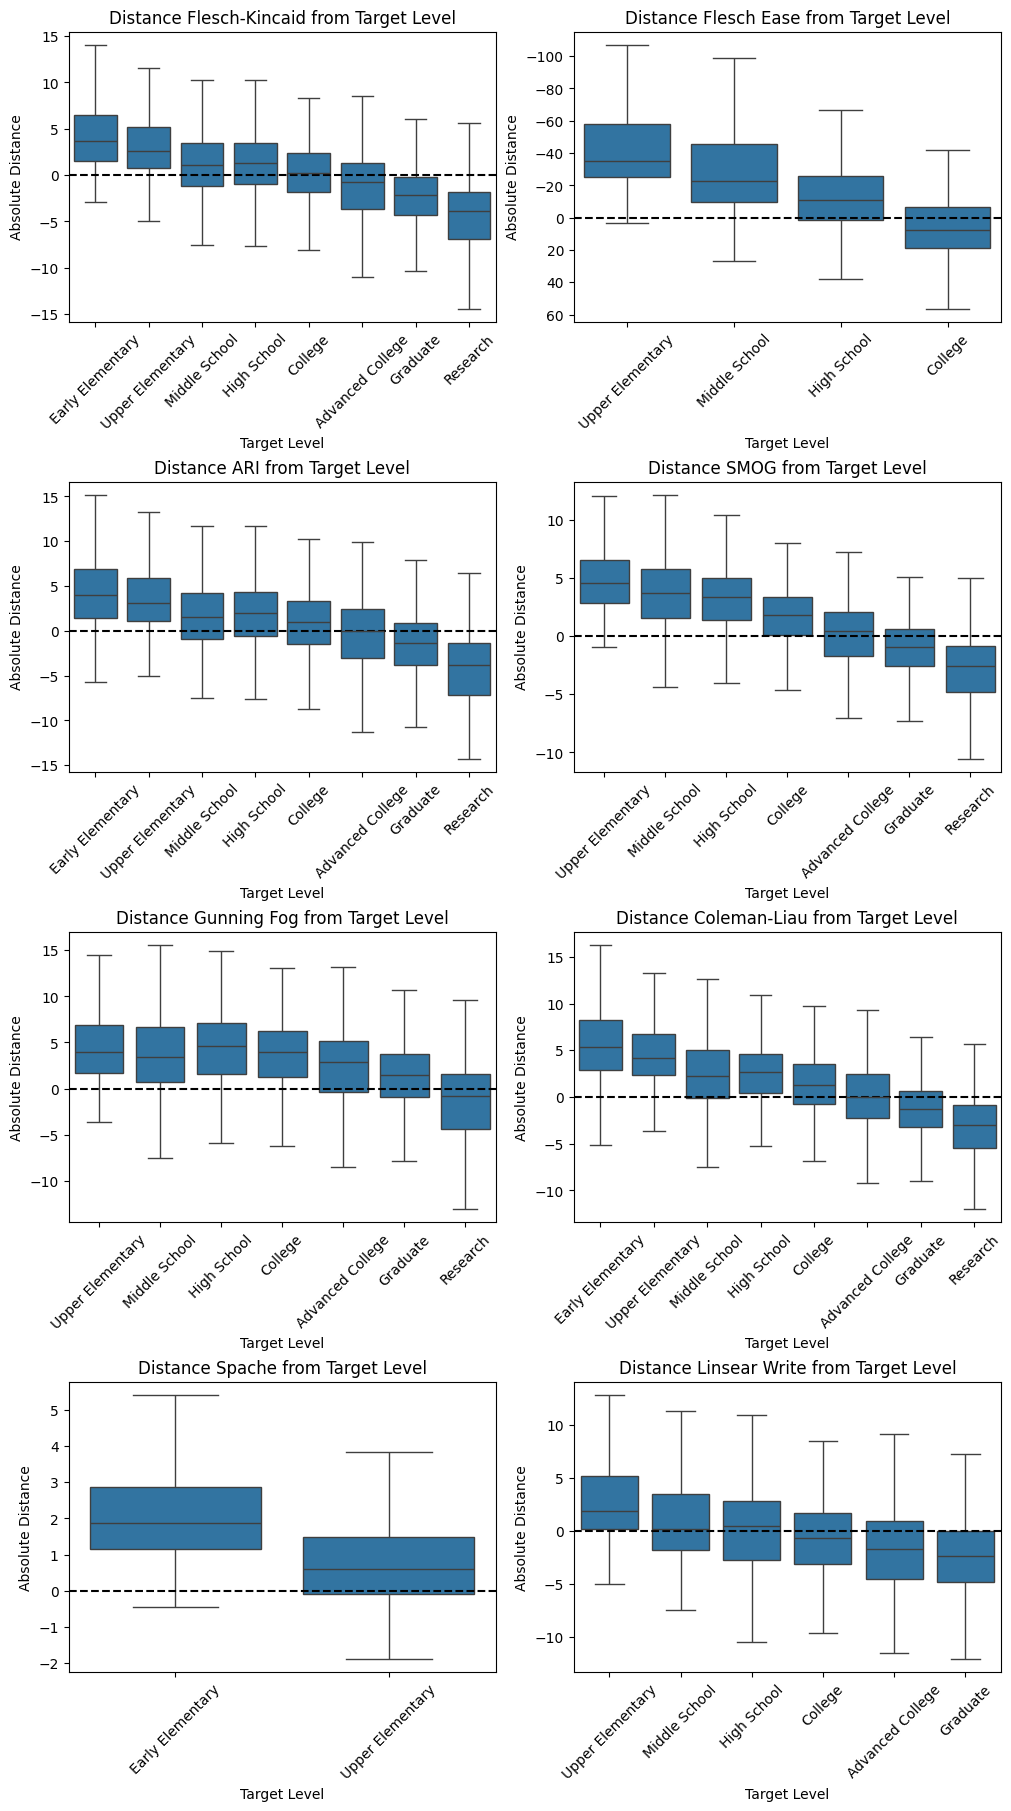

In [22]:
# Signed distance Target - Result

distance_metrics = [
    'Distance Flesch-Kincaid', 'Distance Flesch Ease', 'Distance ARI',
    'Distance SMOG', 'Distance Gunning Fog', 'Distance Coleman-Liau',
    'Distance Spache', 'Distance Linsear Write'
]

n_metrics = len(distance_metrics)
n_cols = 2
n_rows = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 18), constrained_layout=True)
axes = axes.flatten()

for i, metric in enumerate(distance_metrics):
    plot_df = df_all[['Target Level', metric]].dropna()
    
    # Filter levels actually present in the current data
    present_levels = sorted(
        plot_df['Target Level'].unique(),
        key=lambda x: READABILITY_LEVELS.index(x)
    )

    # Apply only present levels as categorical ordering
    plot_df['Target Level'] = pd.Categorical(
        plot_df['Target Level'],
        categories=present_levels,
        ordered=True
    )

    sns.boxplot(data=plot_df, x='Target Level', y=metric, ax=axes[i], showfliers=False)
    axes[i].set_title(metric + ' from Target Level')
    axes[i].set_xlabel('Target Level')
    axes[i].set_ylabel('Absolute Distance')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].axhline(0, color='black', linewidth=1.5, linestyle='--')
    
    if metric == 'Distance Flesch Ease':
        axes[i].invert_yaxis()

# Hide any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.savefig("readability_plots_distance12B.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [24]:
df_allcpy = df_all.copy()

In [25]:
distance_metrics_adapted = [
    'Distance Flesch-Kincaid Adapted', 'Distance Flesch Ease Adapted', 'Distance ARI Adapted',
    'Distance SMOG Adapted', 'Distance Gunning Fog Adapted', 'Distance Coleman-Liau Adapted',
    'Distance Spache Adapted', 'Distance Linsear Write Adapted'
]

In [26]:
df_allcpy['Mean Distance'] = df_allcpy[distance_metrics_adapted].mean(axis=1)

In [27]:
# Application of ANOVA

model = ols('Q("Mean Distance") ~ C(Technique) + C(Topic) + C(Q("Target Level")) + C(Q("Output Length")) + C(Model)', data=df_allcpy).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                            sum_sq       df            F         PR(>F)
C(Technique)             59.780788      4.0   213.124153  1.793812e-178
C(Topic)                  9.708256      4.0    34.610848   8.118775e-29
C(Q("Target Level"))    116.419082      7.0   237.168580   0.000000e+00
C(Q("Output Length"))    14.876929      4.0    53.037655   1.814787e-44
C(Model)                 91.913215      1.0  1310.717159  6.290229e-276
Residual               1122.060050  16001.0          NaN            NaN


In [28]:
# Application of Tukey HSD

for factor in ['Technique', 'Topic', 'Target Level', 'Output Length', 'Model']:
    df_allcpy[factor] = df_allcpy[factor].astype(str)

    # Run Tukey HSD
    tukey = pairwise_tukeyhsd(df_allcpy['Mean Distance'], df_allcpy[factor], alpha=0.05)
    print(f"\nTukey HSD for {factor}")
    print(tukey.summary())


Tukey HSD for Technique
                   Multiple Comparison of Means - Tukey HSD, FWER=0.05                    
          group1                    group2          meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------------
         Chain-of-Thought Chain-of-Thought-Advanced   0.0013 0.9998 -0.0185  0.0211  False
         Chain-of-Thought                  Few-Shot  -0.0823    0.0 -0.1021 -0.0625   True
         Chain-of-Thought                  Two-Step   0.0949    0.0  0.0751  0.1147   True
         Chain-of-Thought                 Zero-Shot  -0.0553    0.0 -0.0751 -0.0355   True
Chain-of-Thought-Advanced                  Few-Shot  -0.0836    0.0 -0.1034 -0.0638   True
Chain-of-Thought-Advanced                  Two-Step   0.0936    0.0  0.0738  0.1134   True
Chain-of-Thought-Advanced                 Zero-Shot  -0.0566    0.0 -0.0764 -0.0368   True
                 Few-Shot                  Two-Step   0.1772    0

In [29]:
# Output of top and tail combinations based on Mean Distance
df_allcpy['Output Length'] = df_allcpy['Output Length'].astype(str)

df_allcpy['Combo'] = (
    df_allcpy['Technique'] + " | " +
    df_allcpy['Target Level'] + " | " +
    df_allcpy['Topic'] + " | " +
    df_allcpy['Output Length'] + " | " +
    df_allcpy['Model']
)

best = df_allcpy.groupby('Combo')['Mean Distance'].mean().sort_values()

print(best)

Combo
Chain-of-Thought | Middle School | human aging | 200 | meta-llama/Llama-3.1-8B-Instruct         0.088653
Zero-Shot | Middle School | human aging | 200 | mistralai/Mistral-Nemo-Instruct-2407            0.089312
Chain-of-Thought | Middle School | nutrition | 100 | meta-llama/Llama-3.1-8B-Instruct           0.090018
Two-Step | Research | human aging | 200 | mistralai/Mistral-Nemo-Instruct-2407                  0.092462
Two-Step | Research | human aging | 200 | meta-llama/Llama-3.1-8B-Instruct                      0.094890
                                                                                                  ...   
Two-Step | Early Elementary | human aging | 100 | mistralai/Mistral-Nemo-Instruct-2407          1.565312
Two-Step | Early Elementary | computer security | 50 | mistralai/Mistral-Nemo-Instruct-2407     1.569353
Two-Step | Early Elementary | computer security | 150 | mistralai/Mistral-Nemo-Instruct-2407    1.573208
Two-Step | Early Elementary | computer security |

In [30]:
print(best.head(30))

Combo
Chain-of-Thought | Middle School | human aging | 200 | meta-llama/Llama-3.1-8B-Instruct        0.088653
Zero-Shot | Middle School | human aging | 200 | mistralai/Mistral-Nemo-Instruct-2407           0.089312
Chain-of-Thought | Middle School | nutrition | 100 | meta-llama/Llama-3.1-8B-Instruct          0.090018
Two-Step | Research | human aging | 200 | mistralai/Mistral-Nemo-Instruct-2407                 0.092462
Two-Step | Research | human aging | 200 | meta-llama/Llama-3.1-8B-Instruct                     0.094890
Zero-Shot | Middle School | nutrition | 150 | mistralai/Mistral-Nemo-Instruct-2407             0.097103
Chain-of-Thought | Middle School | human aging | 150 | meta-llama/Llama-3.1-8B-Instruct        0.098388
Zero-Shot | Research | human aging | 200 | meta-llama/Llama-3.1-8B-Instruct                    0.102542
Chain-of-Thought | Middle School | human aging | 50 | meta-llama/Llama-3.1-8B-Instruct         0.103376
Two-Step | Graduate | human aging | 200 | meta-llama/Llama

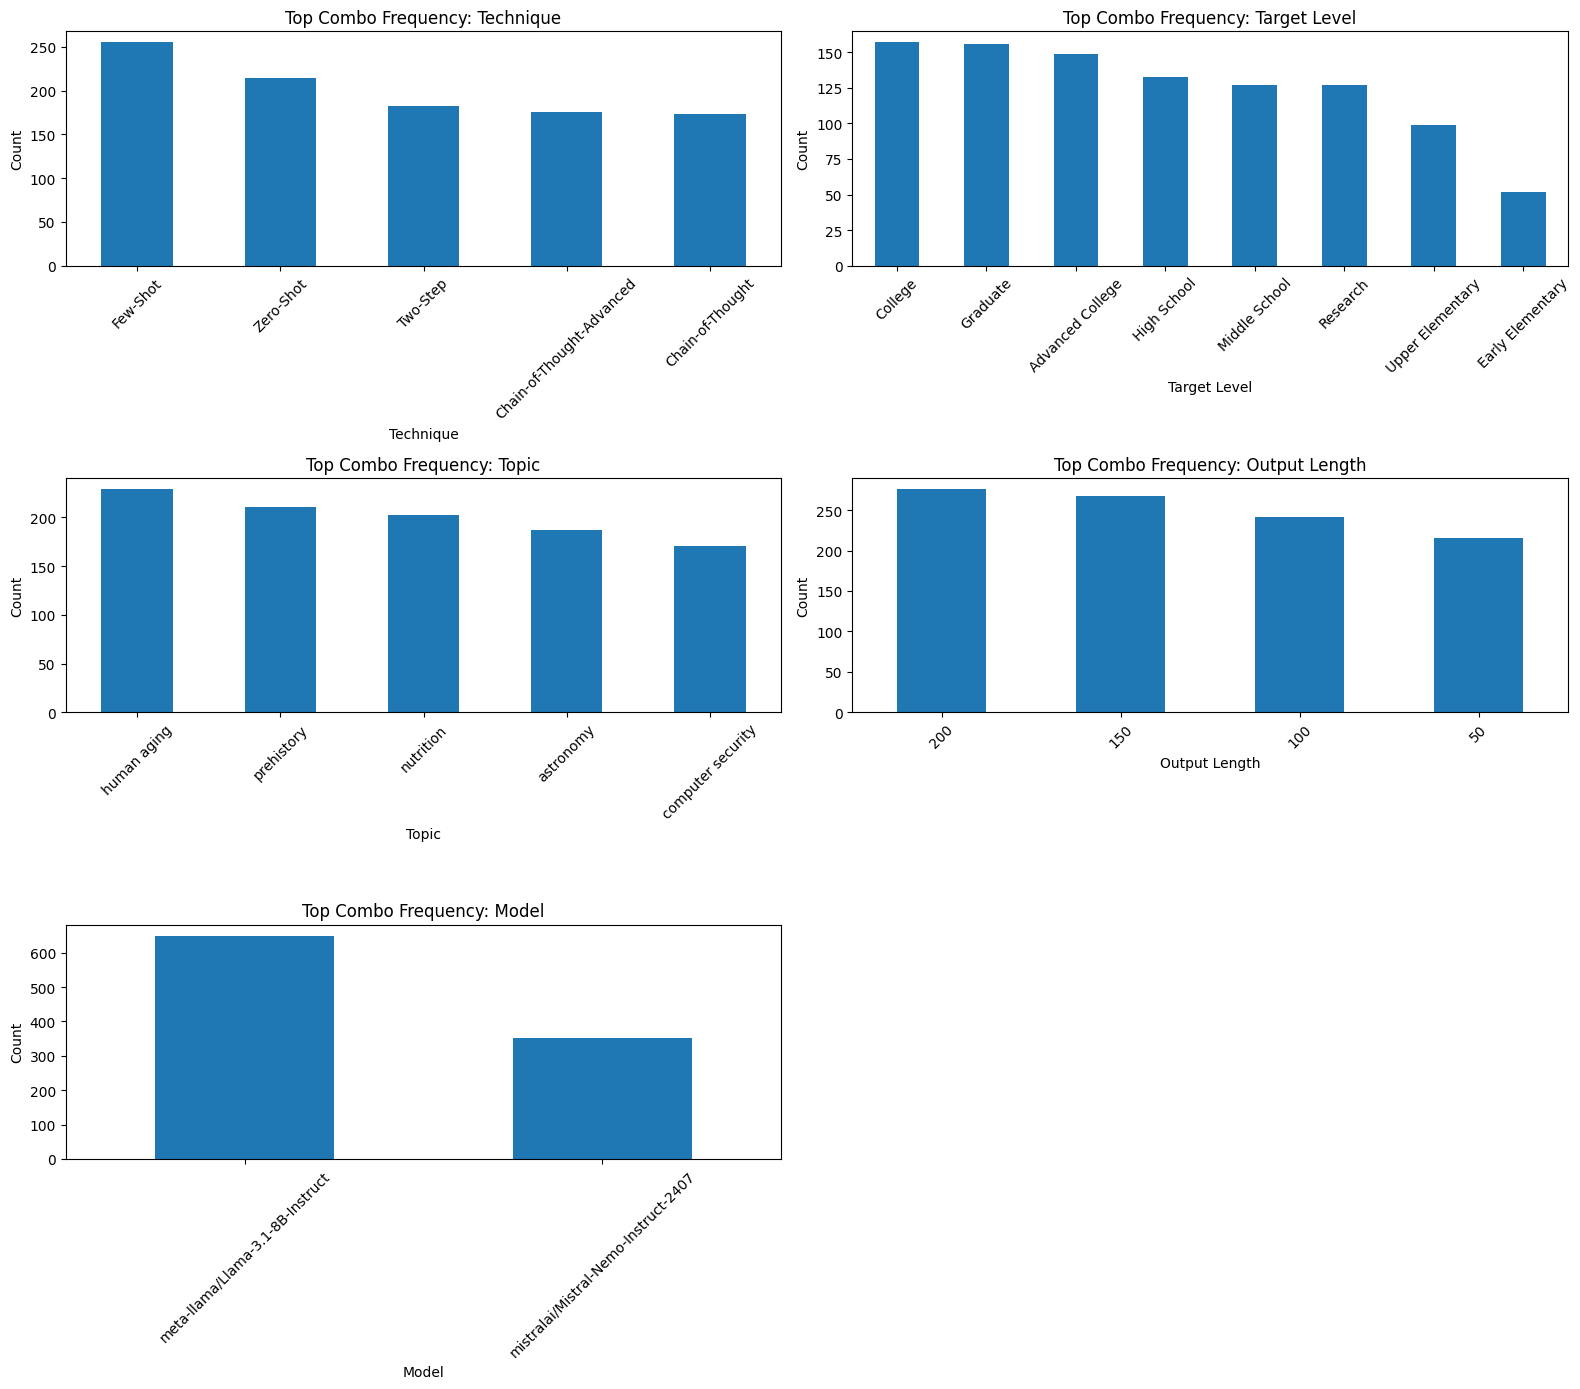

In [54]:
# Plotting statistics about factors of best performing combinations using PyPlot
resultscombo = pd.DataFrame(best.head(1000))
resultscombo.columns = ['Mean Distance']
resultscombo = resultscombo.reset_index()
resultscombo.rename(columns={'index': 'Combo'}, inplace=True)

resultscombo[['Technique', 'Target Level', 'Topic', 'Output Length', 'Model']] = resultscombo['Combo'].str.split(" \| ", expand=True)

params = ['Technique', 'Target Level', 'Topic', 'Output Length', 'Model']
counts = {param: resultscombo[param].value_counts() for param in params}

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 14))
axes = axes.flatten()

for i, param in enumerate(params):
    ax = axes[i]
    counts[param].plot(kind='bar', ax=ax)
    ax.set_title(f"Top Combo Frequency: {param}")
    ax.set_ylabel("Count")
    ax.set_xlabel(param)
    ax.tick_params(axis='x', rotation=45)

if len(params) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig("top_combo_readability12B.pdf", format="pdf", bbox_inches="tight")
plt.show()

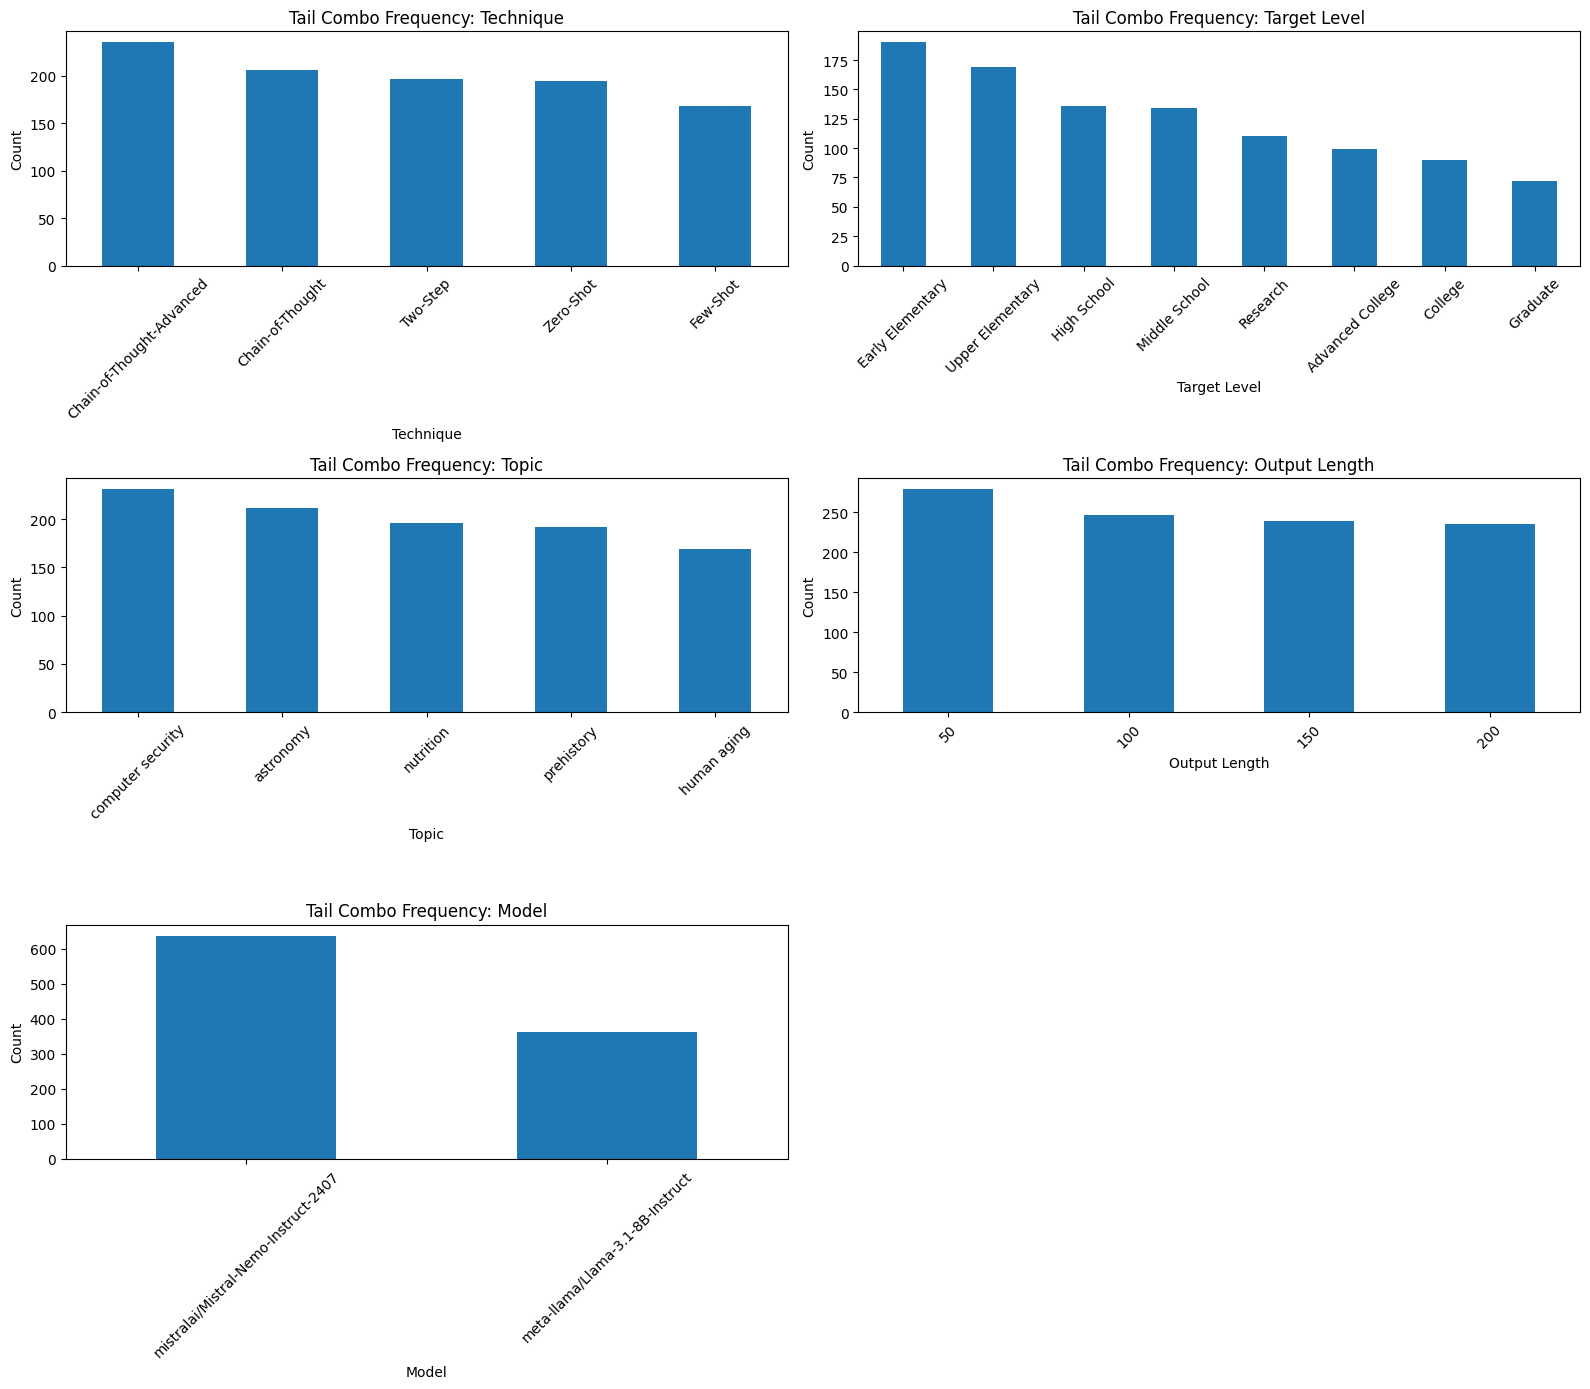

In [55]:
# Plotting statistics about factors of worst performing combinations using PyPlot
resultscombo = pd.DataFrame(best.tail(1000))
resultscombo.columns = ['Mean Distance']
resultscombo = resultscombo.reset_index()
resultscombo.rename(columns={'index': 'Combo'}, inplace=True)

resultscombo[['Technique', 'Target Level', 'Topic', 'Output Length', 'Model']] = resultscombo['Combo'].str.split(" \| ", expand=True)

params = ['Technique', 'Target Level', 'Topic', 'Output Length', 'Model']
counts = {param: resultscombo[param].value_counts() for param in params}

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 14))
axes = axes.flatten()

for i, param in enumerate(params):
    ax = axes[i]
    counts[param].plot(kind='bar', ax=ax)
    ax.set_title(f"Tail Combo Frequency: {param}")
    ax.set_ylabel("Count")
    ax.set_xlabel(param)
    ax.tick_params(axis='x', rotation=45)

if len(params) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig("tail_combo_readability12B.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
# Additional functions for calculating semantic similarity

def extract_summary(prompt):
    try:
        return prompt.split(":\n\n", 1)[-1].strip()
    except Exception:
        return ""

def compute_similarity(row):
    original = row['Original Summary']
    rewritten = row['Text']
    if not original or not rewritten:
        return None
    embeddings = model.encode([original, rewritten], convert_to_tensor=True)
    similarity = util.cos_sim(embeddings[0], embeddings[1]).item()
    return round(similarity, 3)

In [35]:
# Semantic similarity for Two-Step prompting technique between initial output and rewritten one

model = SentenceTransformer('all-MiniLM-L6-v2')

df_two_step = df_allcpy[df_allcpy['Technique'] == 'Two-Step'].copy()

df_two_step['Original Summary'] = df_two_step['Rewrite Prompt'].apply(extract_summary)

df_two_step['Semantic Similarity'] = df_two_step.apply(compute_similarity, axis=1)

threshold = 0.75
df_two_step['Meaning Preserved'] = df_two_step['Semantic Similarity'] >= threshold

columns_for_stats = ['Technique', 'Topic', 'Target Level', 'Output Length', 'Model', 
                     'Original Summary', 'Text', 'Semantic Similarity', 'Meaning Preserved']

df_result = df_two_step[columns_for_stats]

In [36]:
df_result

,Technique,Topic,Target Level,Output Length,Model,Original Summary,Text,Semantic Similarity,Meaning Preserved
0,Two-Step,human aging,High School,200,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,'Human aging' refers to the progressive change...,0.937,True
1,Two-Step,human aging,High School,200,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,"""Human aging is a complex, multifactorial proc...",0.975,True
2,Two-Step,human aging,High School,200,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,"In a nutshell, human aging is a complex, multi...",0.943,True
3,Two-Step,human aging,High School,200,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,The term 'human aging' refers to the gradual a...,0.978,True
4,Two-Step,human aging,High School,200,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,"Human aging is a complex, multifaceted process...",0.947,True
...,...,...,...,...,...,...,...,...,...
16017,Two-Step,human aging,Advanced College,100,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,"""Human aging is a complex, multifactorial proc...",0.961,True
16018,Two-Step,human aging,Advanced College,100,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Human aging is a complex process characterized...,0.925,True
16019,Two-Step,human aging,Advanced College,100,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,"Human aging is a complex, multifactorial proce...",0.906,True
16020,Two-Step,human aging,Advanced College,100,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Human aging is a complex biological process ch...,0.767,True


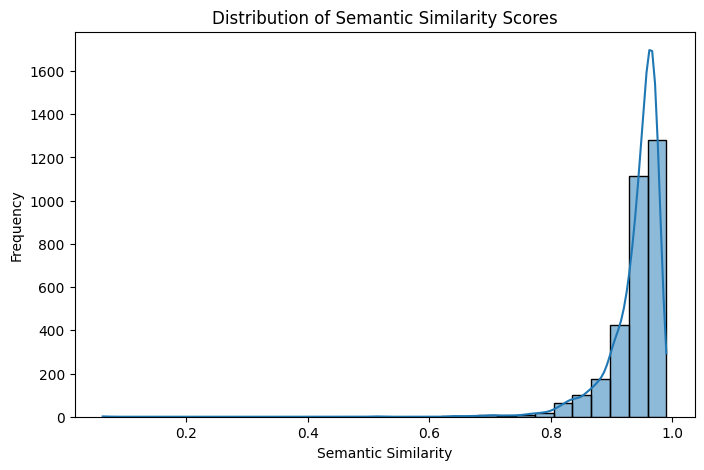

In [38]:
# Plotting of semantic scors distribution for Two-Step technique
plt.figure(figsize=(8,5))
sns.histplot(df_result['Semantic Similarity'].dropna(), bins=30, kde=True)

plt.title('Distribution of Semantic Similarity Scores')
plt.xlabel('Semantic Similarity')
plt.ylabel('Frequency')
plt.savefig("semantic_similarity12B.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
# Additional function to calculate similarity

def compute_similarity(row):
    topic = row['Topic']
    text = row['Text']
    if not topic or not text:
        return None
    embeddings = model.encode([topic, text], convert_to_tensor=True)
    similarity = util.cos_sim(embeddings[0], embeddings[1]).item()
    return round(similarity, 3)

In [40]:
# Plotting of semantic scors distribution for Topic - Output
model = SentenceTransformer('all-MiniLM-L6-v2')

df_all_filtered = df_allcpy.dropna(subset=['Topic', 'Text']).copy()

df_all_filtered['Semantic Similarity'] = df_all_filtered.apply(compute_similarity, axis=1)

threshold = 0.75
df_all_filtered['Meaning Preserved'] = df_all_filtered['Semantic Similarity'] >= threshold
df_result2 = df_all_filtered

In [41]:
df_result2

,Technique,Topic,Target Level,Output Length,Model,Prompt,Rewrite Prompt,Text,Flesch-Kincaid,Flesch Ease,...,Distance ARI Adapted,Distance Coleman-Liau Adapted,Distance Gunning Fog Adapted,Distance SMOG Adapted,Distance Spache Adapted,Distance Linsear Write Adapted,Mean Distance,Combo,Semantic Similarity,Meaning Preserved
0,Two-Step,human aging,High School,200,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,'Human aging' refers to the progressive change...,16.152707,12.874226,...,0.393025,0.421233,0.675258,0.539657,NaN,0.242424,0.426744,Two-Step | High School | human aging | 200 | m...,0.723,False
1,Two-Step,human aging,High School,200,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,"""Human aging is a complex, multifactorial proc...",16.950047,5.302391,...,0.454038,0.525759,0.717583,0.519013,NaN,0.303030,0.481997,Two-Step | High School | human aging | 200 | m...,0.638,False
2,Two-Step,human aging,High School,200,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,"In a nutshell, human aging is a complex, multi...",17.848822,5.834612,...,0.535099,0.504526,0.849103,0.622604,NaN,0.647727,0.579556,Two-Step | High School | human aging | 200 | m...,0.723,False
3,Two-Step,human aging,High School,200,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,The term 'human aging' refers to the gradual a...,14.314669,28.352610,...,0.289603,0.244783,0.492937,0.395639,NaN,0.354545,0.313932,Two-Step | High School | human aging | 200 | m...,0.803,True
4,Two-Step,human aging,High School,200,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,"Human aging is a complex, multifaceted process...",18.231018,3.285294,...,0.490288,0.460825,0.884265,0.658088,NaN,0.590909,0.576473,Two-Step | High School | human aging | 200 | m...,0.604,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16017,Two-Step,human aging,Advanced College,100,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,"""Human aging is a complex, multifactorial proc...",17.935811,-0.577635,...,0.278174,0.348986,0.476324,0.182817,NaN,0.068182,0.248301,Two-Step | Advanced College | human aging | 10...,0.773,True
16018,Two-Step,human aging,Advanced College,100,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,Human aging is a complex process characterized...,19.476408,-5.834353,...,0.376437,0.371193,0.559448,0.294393,NaN,0.329545,0.358655,Two-Step | Advanced College | human aging | 10...,0.714,False
16019,Two-Step,human aging,Advanced College,100,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,"Human aging is a complex, multifactorial proce...",15.725000,10.820000,...,0.164564,0.278711,0.122000,0.049481,NaN,0.250000,0.146209,Two-Step | Advanced College | human aging | 10...,0.732,False
16020,Two-Step,human aging,Advanced College,100,mistralai/Mistral-Nemo-Instruct-2407,Write a summary about 'human aging'. Limit the...,Rewrite the following text to match the readab...,Human aging is a complex biological process ch...,17.090571,2.454429,...,0.207922,0.302827,0.440457,0.135201,NaN,0.054545,0.204886,Two-Step | Advanced College | human aging | 10...,0.668,False


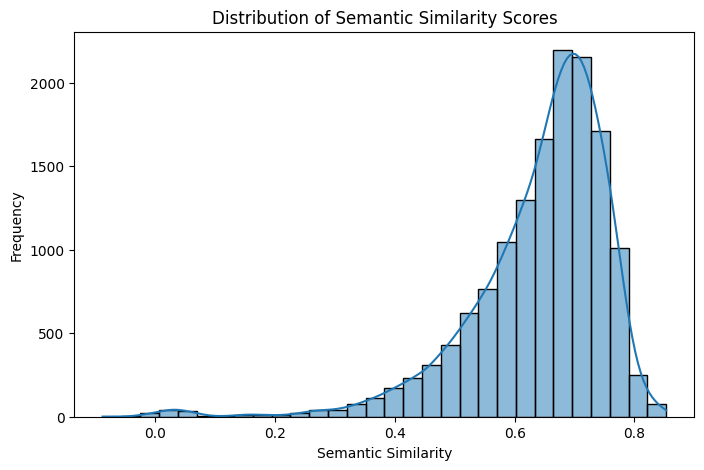

In [43]:
# Plot of Semantic similarity between Topic and Output between different prompting techniques
plt.figure(figsize=(8,5))
sns.histplot(df_result2['Semantic Similarity'].dropna(), bins=30, kde=True)

plt.title('Distribution of Semantic Similarity Scores')
plt.xlabel('Semantic Similarity')
plt.ylabel('Frequency')
plt.savefig("semantic_similarity_topic12B.pdf", format="pdf", bbox_inches="tight")
plt.show()

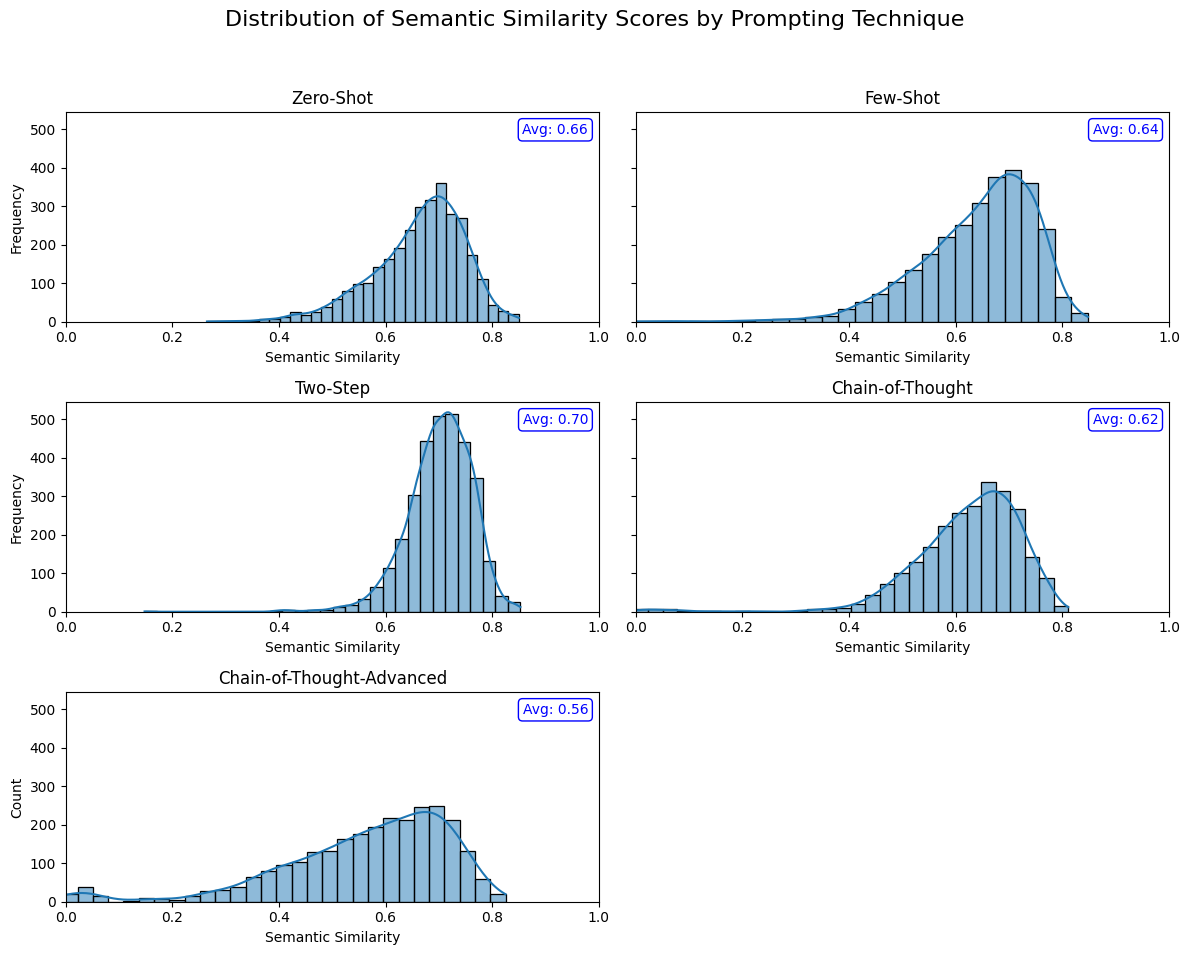

In [44]:
# Distribution of Similarity Scores between Prompting techniques

prompting_techniques = ['Zero-Shot', 'Few-Shot', 'Two-Step', 'Chain-of-Thought', 'Chain-of-Thought-Advanced']

fig, axes = plt.subplots(3, 2, figsize=(12, 10), sharey=True)

for ax, technique in zip(axes.flat, prompting_techniques):
    subset = df_result2[df_result2['Technique'] == technique]
    data = subset['Semantic Similarity'].dropna()
    
    sns.histplot(data, bins=30, kde=True, ax=ax)
    
    mean_similarity = data.mean()

    ax.text(0.98, 0.95, f'Avg: {mean_similarity:.2f}', transform=ax.transAxes,
            color='blue', ha='right', va='top', fontsize=10,
            bbox=dict(facecolor='white', edgecolor='blue', boxstyle='round,pad=0.3'))

    ax.set_title(technique)
    ax.set_xlabel('Semantic Similarity')
    ax.set_xlim(0, 1)

fig.delaxes(axes[2, 1])
axes[0, 0].set_ylabel('Frequency')
axes[1, 0].set_ylabel('Frequency')

plt.suptitle('Distribution of Semantic Similarity Scores by Prompting Technique', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("semantic_similarity_topic_prompting_technique12B.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [47]:
# Statistical analysis of semantic similarity using ANOVA

model = ols('Q("Semantic Similarity") ~ C(Technique) + C(Topic) + C(Q("Target Level")) + C(Q("Output Length")) + C(Model)', data=df_result2).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                           sum_sq       df           F         PR(>F)
C(Technique)            29.527270      4.0  751.177030   0.000000e+00
C(Topic)                 5.052843      4.0  128.544881  4.977533e-108
C(Q("Target Level"))    10.632224      7.0  154.562831  5.334422e-221
C(Q("Output Length"))    1.423824      3.0   48.296326   4.772466e-31
C(Model)                 5.321792      1.0  541.547921  1.290136e-117
Residual               141.066602  14355.0         NaN            NaN


In [48]:
# Statistical analysis of semantic similarity using Tukey HSD

for factor in ['Technique', 'Topic', 'Target Level', 'Output Length', 'Model']:
    print(f"\nTukey HSD for {factor}")
    
    df_result2_tukey = df_result2.filter(items=['Semantic Similarity', factor]).dropna()
    tukey = pairwise_tukeyhsd(df_result2_tukey['Semantic Similarity'], df_result2_tukey[factor], alpha=0.05)
    print(tukey.summary())


Tukey HSD for Technique
                   Multiple Comparison of Means - Tukey HSD, FWER=0.05                   
          group1                    group2          meandiff p-adj  lower   upper  reject
-----------------------------------------------------------------------------------------
         Chain-of-Thought Chain-of-Thought-Advanced  -0.0619   0.0   -0.07 -0.0538   True
         Chain-of-Thought                  Few-Shot   0.0184   0.0  0.0104  0.0263   True
         Chain-of-Thought                  Two-Step   0.0787   0.0  0.0709  0.0864   True
         Chain-of-Thought                 Zero-Shot   0.0399   0.0   0.032  0.0477   True
Chain-of-Thought-Advanced                  Few-Shot   0.0802   0.0  0.0724  0.0881   True
Chain-of-Thought-Advanced                  Two-Step   0.1405   0.0  0.1329  0.1481   True
Chain-of-Thought-Advanced                 Zero-Shot   0.1017   0.0  0.0941  0.1094   True
                 Few-Shot                  Two-Step   0.0603   0.0  0.0528 

In [ ]:
# Additional techniques for plotting

READABILITY_LEVELS = [
    "Early Elementary",
    "Upper Elementary",
    "Middle School",
    "High School",
    "College",
    "Advanced College",
    "Graduate",
    "Research"
]

def invert_mapping(mapping, is_range=False):
    level_to_values = defaultdict(list)
    if is_range:
        for rng, level in mapping.items():
            level_to_values[level].append(rng)
    else:
        for score, level in mapping.items():
            level_to_values[level].append(score)
    return level_to_values

# Define mapping per metric
metric_to_mapping = {
    'Flesch-Kincaid': FLESCH_KINCAID_GRADE,
    'Flesch Ease': FLESCH_READING_EASE,
    'ARI': ARI,
    'SMOG': SMOG_INDEX,
    'Gunning Fog': GUNNING_FOG,
    'Coleman-Liau': COLEMAN_LIAU,
    'Spache': SPACHE,
    'Linsear Write': LINSEAR_WRITE,
}

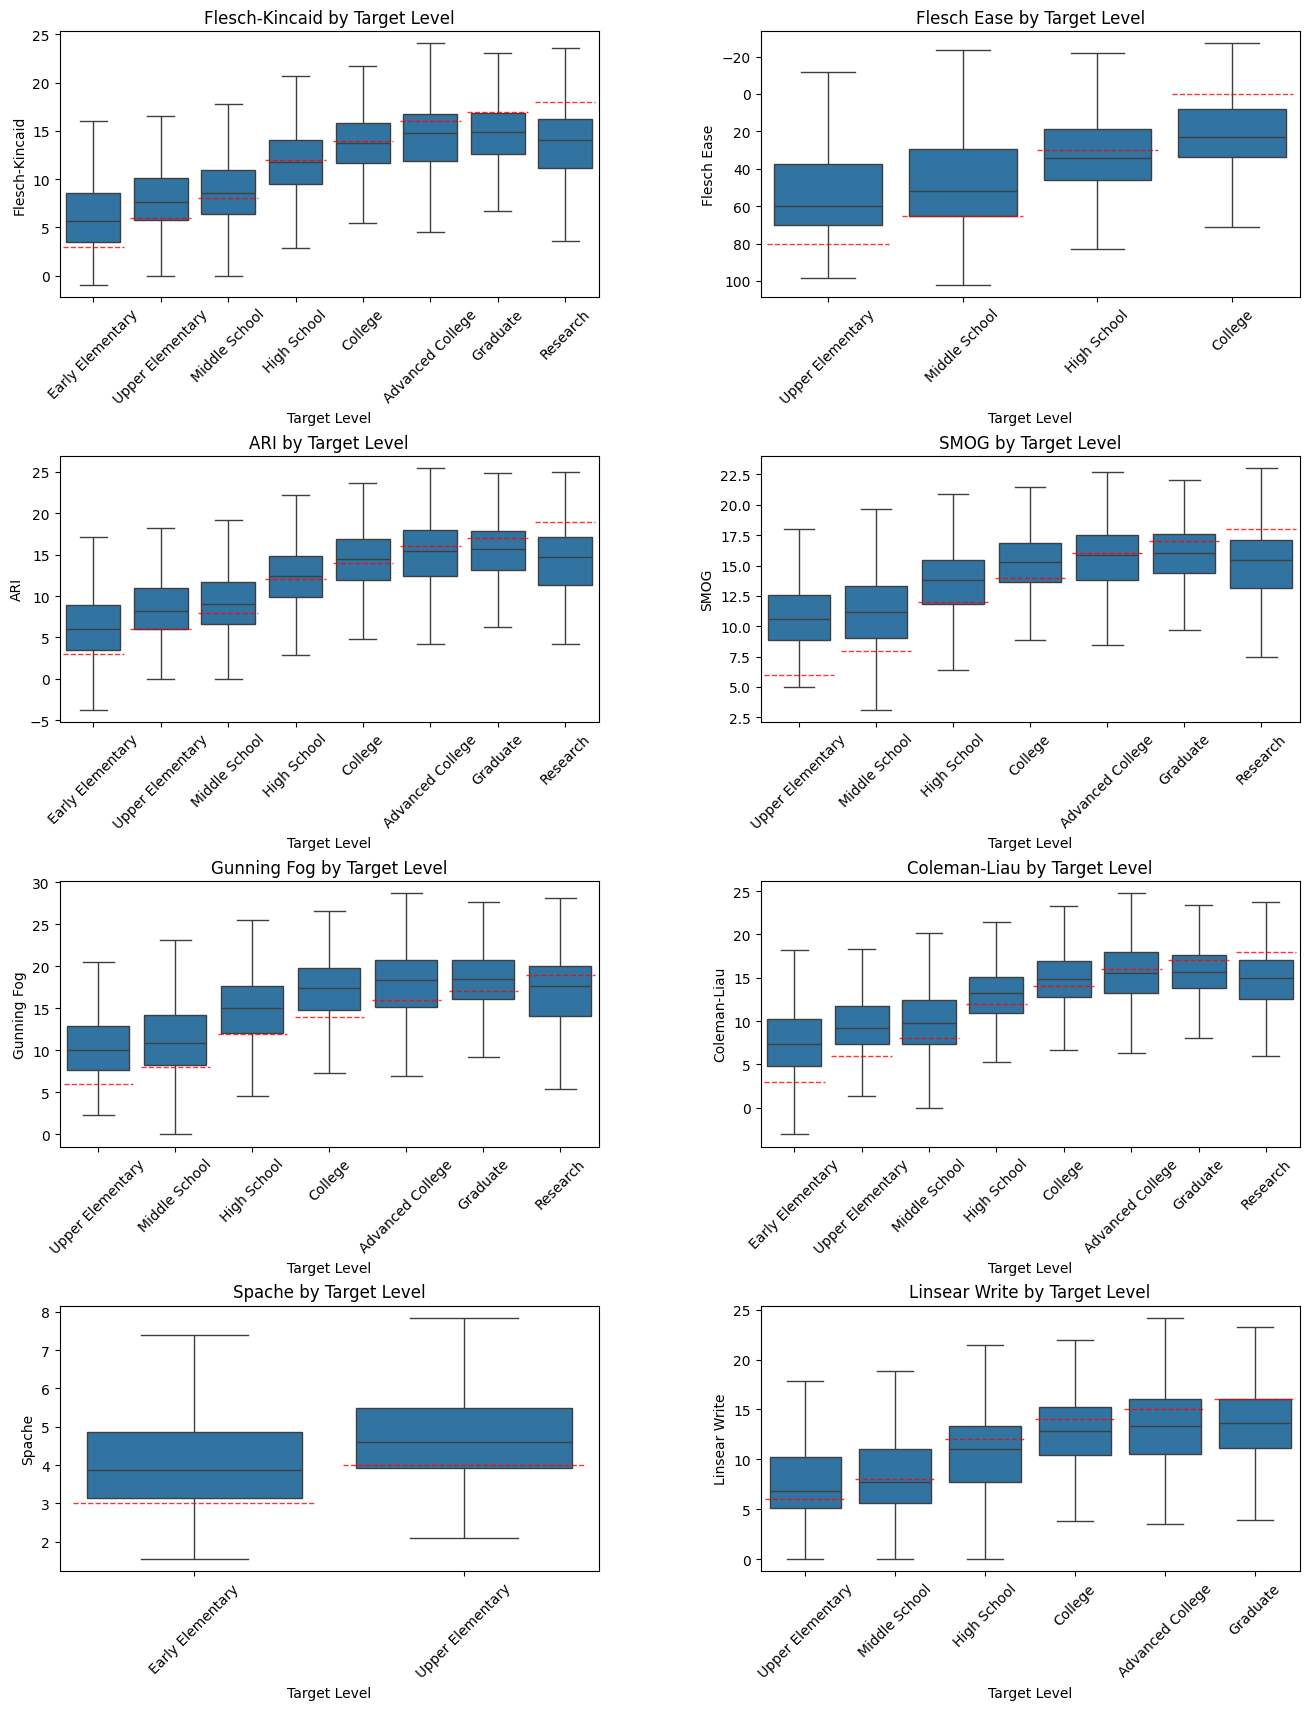

In [53]:
# Plotting of metric scores across Target levels

metrics = list(metric_to_mapping.keys())
flesch_df = df_allcpy[metrics + ['Target Level']].dropna()

valid_metrics = []
for metric in metrics:
    mapping = metric_to_mapping[metric]
    is_range = any(isinstance(k, tuple) for k in mapping.keys())
    level_to_values = invert_mapping(mapping, is_range)
    supported_levels = set(level_to_values.keys())

    df_metric = flesch_df[flesch_df['Target Level'].isin(supported_levels)]
    levels_in_data = [lvl for lvl in READABILITY_LEVELS if lvl in df_metric['Target Level'].unique()]
    if levels_in_data:
        valid_metrics.append(metric)

n_metrics = len(valid_metrics)
n_cols = 2
n_rows = (n_metrics + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5 * n_rows))
axes = axes.flatten()

for plot_idx, metric in enumerate(valid_metrics):
    ax = axes[plot_idx]

    mapping = metric_to_mapping[metric]
    is_range = any(isinstance(k, tuple) for k in mapping.keys())
    level_to_values = invert_mapping(mapping, is_range)
    supported_levels = set(level_to_values.keys())

    df_metric = flesch_df[flesch_df['Target Level'].isin(supported_levels)].copy()
    levels_in_data = [lvl for lvl in READABILITY_LEVELS if lvl in df_metric['Target Level'].unique()]
    df_metric = df_metric[df_metric['Target Level'].isin(levels_in_data)].copy()
    df_metric['Target Level'] = pd.Categorical(df_metric['Target Level'], categories=levels_in_data, ordered=True)

    sns.boxplot(data=df_metric, x='Target Level', y=metric, ax=ax, showfliers=False)
    ax.set_title(f'{metric} by Target Level')
    ax.set_xlabel('Target Level')
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=45)

    if metric == "Flesch Ease":
        ax.invert_yaxis()

    for xtick, level in enumerate(levels_in_data):
        if level in level_to_values:
            values = level_to_values[level]
            if is_range:
                y = min([low for (low, _) in values]) if metric == "Flesch Ease" else max([high for (_, high) in values])
            else:
                y = max(values)

            ax.axhline(
                y=y,
                xmin=(xtick + 0.05) / len(levels_in_data),
                xmax=(xtick + 0.95) / len(levels_in_data),
                color='red',
                linestyle='--',
                linewidth=1,
                alpha=0.8
            )

# Remove unused axes
for j in range(len(valid_metrics), len(axes)):
    fig.delaxes(axes[j])

plt.subplots_adjust(hspace=0.6, wspace=0.3)
plt.savefig("target_level_values12B.pdf", format="pdf", bbox_inches="tight")
plt.show()